Import stuff and initialize global parameters.

In [55]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Flatten, Dense, LSTM, \
    MaxPooling2D
from keras.models import Sequential
from common import extract_training_data

IMAGE_SIZE = (64, 64, 3)

# LSTM network
Reading data and creating initial model.

In [56]:
images, labels = extract_training_data("Data/20171029-201949.h264.avi", "Data/20171029-201949.h264.csv", IMAGE_SIZE)

In [57]:
y_train = labels.as_matrix(columns=labels.columns[1: -1])
y_train.shape

(1744, 3)

In [58]:
images.shape

(1744, 64, 64, 3)

In [59]:
from keras.layers import Permute, Reshape

model = Sequential()
model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Permute((3, 2, 1)))
model.add(Reshape((4, 7688)))
#model.add(Flatten())
model.add(LSTM(64, return_sequences=False))
model.add(Dense(3, activation='linear'))

model.compile(loss="mse", optimizer="adam")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
permute_12 (Permute)         (None, 32, 31, 31)        0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 4, 7688)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                1984768   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 195       
Total params: 1,985,859
Trainable params: 1,985,859
Non-trainable params: 0
_________________________________________________________________


### LSTM network results

In [60]:
history = model.fit(images, y_train, batch_size=64, epochs=10, validation_split=0.04)

Train on 1674 samples, validate on 70 samples
Epoch 1/10
1674/1674 [==============================] - 1s - loss: 0.3213 - val_loss: 0.1518
Epoch 2/10
1674/1674 [==============================] - 0s - loss: 0.1187 - val_loss: 0.2212
Epoch 3/10
1674/1674 [==============================] - 0s - loss: 0.0961 - val_loss: 0.2288
Epoch 4/10
1674/1674 [==============================] - 0s - loss: 0.0835 - val_loss: 0.2339ss: 
Epoch 5/10
1674/1674 [==============================] - 0s - loss: 0.0719 - val_loss: 0.2456
Epoch 6/10
1674/1674 [==============================] - 0s - loss: 0.0645 - val_loss: 0.2534
Epoch 7/10
1674/1674 [==============================] - 0s - loss: 0.0602 - val_loss: 0.2648
Epoch 8/10
1674/1674 [==============================] - 0s - loss: 0.0568 - val_loss: 0.2703
Epoch 9/10
1674/1674 [==============================] - 0s - loss: 0.0542 - val_loss: 0.2785
Epoch 10/10
1674/1674 [==============================] - 0s - loss: 0.0531 - val_loss: 0.2774


In [61]:
test_images, test_labels = extract_training_data("Data/20171029-201639.h264.avi", 
                                                            "Data/20171029-201639.h264.csv", 
                                                            IMAGE_SIZE)

prediction = model.predict(test_images)

In [62]:
prediction

array([[ 0.11236326,  0.03893948,  0.98364413],
       [ 0.10572665,  0.03254712,  0.97574234],
       [ 0.10332077,  0.03395949,  0.97701836],
       ..., 
       [-0.42014229, -0.01613564,  0.92864823],
       [-0.4234415 , -0.0149938 ,  0.92871475],
       [-0.41632813, -0.01745694,  0.9285903 ]], dtype=float32)

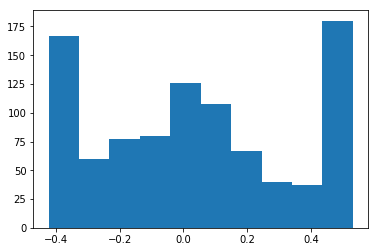

In [63]:
plt.hist(prediction[:, 0])
plt.show()

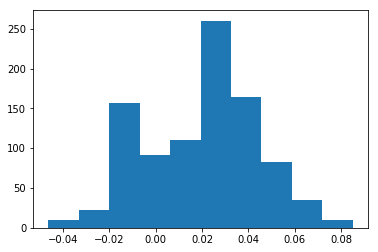

In [64]:
plt.hist(prediction[:, 1])
plt.show()

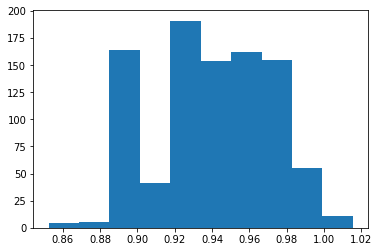

In [65]:
plt.hist(prediction[:, 2])
plt.show()

In [66]:
validation_labels = test_labels.as_matrix(columns=test_labels.columns[1: -1])
clipped_prediction = np.zeros_like(prediction)

clipped_prediction[:, 0] = np.clip(prediction[:, 0], -1, 1)
clipped_prediction[:, 1] = np.clip(prediction[:, 1], 0, 1)
clipped_prediction[:, 2] = np.clip(prediction[:, 2], 0, 1)

print(validation_labels.shape)
print(clipped_prediction.shape)

(942, 3)
(942, 3)


In [68]:
from sklearn.metrics import explained_variance_score
explained_variance_score(validation_labels, prediction)

0.12402683762757764

## K fold cross validation

Currently the model is just a copy of what is above, defined as a function for the KerasRegressor wrapper

In [72]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold, cross_val_score

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Permute((3, 2, 1)))
    model.add(Reshape((4, 7688)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(3, activation='linear'))

    model.compile(loss="mse", optimizer="adam")
    
    return model

model = KerasRegressor(build_fn=create_model, epochs=10, batch_size=64, verbose=0)
kfold = KFold(n_splits=10)

results = cross_val_score(model, images, y_train, cv=kfold, scoring='explained_variance')
results

array([ 0.08098865,  0.11936634,  0.07702581,  0.25818764,  0.06547787,
        0.01311816,  0.15318771,  0.00834547,  0.1972726 ,  0.09054721])